<a href="https://colab.research.google.com/github/nprimavera/Reinforcement-Learning/blob/main/Project5_V14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MECS6616 Spring 2025 - Project 5**

# **Introduction**

***IMPORTANT:***
- **Before starting, make sure to read the [Assignment Instructions](https://courseworks2.columbia.edu/courses/215046/pages/assignment-instructions) page on Courseworks to understand the workflow and submission requirements for this project.**

**FOR PROJECT 5!!!**
- Apart from the link to your notebook, you are also required to submit `q_network.pth` of Part 1 and `ppo_network.zip` (model checkpoints are loaded and saved by stable_baselines3 as zip files) of Part 2 to Coursework. You should put the link to your notebook in the comment entry

# Project Setup


In [1]:
# DO NOT CHANGE

# There will be error messages from this command. You can ignore those error messages
# as long as you see "Successfully installed setuptools-65.5.0" at the end.

# After installing setuptools, a pop-up window will appear and you will be prompted
# to restart the notebook environment. Click on the restart environment button before continuing

!pip install setuptools==65.5.0

**----------------------------**
**WAIT FOR NOTEBOOK TO RESTART**
**----------------------------**

In [2]:
# DO NOT CHANGE

# After running this cell, the folder 'mecs6616_sp25_project5' will show up in the file explorer on the left (click on the folder icon if it's not open)
# It may take a few seconds to appear
!git clone https://github.com/roamlab/mecs6616_sp24_project5.git
!mv /content/mecs6616_sp24_project5 /content/mecs6616_sp25_project5

Cloning into 'mecs6616_sp24_project5'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 15 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (15/15), 9.22 KiB | 1.15 MiB/s, done.


In [3]:
# DO NOT CHANGE

# copy all needed files into the working directory. This is simply to make accessing files easier
!cp -av /content/mecs6616_sp25_project5/* /content/

'/content/mecs6616_sp25_project5/arm_dynamics_base.py' -> '/content/arm_dynamics_base.py'
'/content/mecs6616_sp25_project5/arm_dynamics.py' -> '/content/arm_dynamics.py'
'/content/mecs6616_sp25_project5/arm_env.py' -> '/content/arm_env.py'
'/content/mecs6616_sp25_project5/geometry.py' -> '/content/geometry.py'
'/content/mecs6616_sp25_project5/mecs6616_sp24_project5' -> '/content/mecs6616_sp24_project5'
'/content/mecs6616_sp25_project5/mecs6616_sp24_project5/.git' -> '/content/mecs6616_sp24_project5/.git'
'/content/mecs6616_sp25_project5/mecs6616_sp24_project5/.git/info' -> '/content/mecs6616_sp24_project5/.git/info'
'/content/mecs6616_sp25_project5/mecs6616_sp24_project5/.git/info/exclude' -> '/content/mecs6616_sp24_project5/.git/info/exclude'
'/content/mecs6616_sp25_project5/mecs6616_sp24_project5/.git/branches' -> '/content/mecs6616_sp24_project5/.git/branches'
'/content/mecs6616_sp25_project5/mecs6616_sp24_project5/.git/hooks' -> '/content/mecs6616_sp24_project5/.git/hooks'
'/conten

In [4]:
# DO NOT CHANGE

# There will be error messages from this command. You can ignore those error messages
# as long as you see "Successfully installed gym stable-baselines3" at the end.

!pip install wheel==0.38.4
!pip install gym stable-baselines3
!pip install shimmy>=2.0

  Using cached stable_baselines3-2.6.0-py3-none-any.whl.metadata (4.8 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
Using cached stable_baselines3-2.6.0-py3-none-any.whl (184 kB)
Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)
Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl (127.9 MB)
  Attempting uninstall: nvidia-cudnn-cu12
    Found existing installation: nvidia-cudnn-cu12 9.3.0.75
    Uninstalling nvidia-cudnn-cu12-9.3.0.75:
      Successfully uninstalled nvidia-cudnn-cu12-9.3.0.75
  Attempting uninstall: nvidia-cusolver-cu12
    Found existing installation: nvidia-cusolver-cu12 11.6.3.83
    Uninstalling nvidia-cusolver-cu12-11.6.3.83:
      Successfully uninstalled nvidia-cusolver-cu12-11.6.3.83


# Part 1: Implement DQN

For this part, you will implement DQN from scratch. You SHOULD NOT use any RL libraries.

## Starter Code Explanation
In addition to code you are already familiar with from the previous project (i.e. arm dynamics, etc.) we are providing an "Environment" in the `ArmEnv` class. The environment "wraps around" the arm dynamics and provides the key functions that an RL algorithm expects: reset(...) and step(...). The implementation of `ArmEnv` follows the [OpenAI Gym](https://www.gymlibrary.dev/api/core/) API standard. It is a standard that is accepeted by many RL libraries and allows for our problem to be easily solved with various RL libraries. Take a moment to familiarize yourself with these functions! See [here](https://www.gymlibrary.dev/api/core/) for more information on the definition of the reset(...) and step(...) functions.

Important notes:

* The ArmEnv expects an action similar to the one used previously: a vector with a torque for every arm joint. Thus, the native action space for this environment is high-dimensional, and continuous. DQN will require an action space that is 1-dimensional and discrete. You will need to convert between these. For example, you can have an action space of [0, 1, 2,] where each number just represents the identity of an action candidate, and a conversion dictionary {0: [-0.1, -0.1], 1: [0.1, 0.1], 2: [0, 0]}. Then, when the Q network output an action 1, it will be converted into [0.1, 0.1] and used by the environment. Note that this is just an example method to implement the conversion and you do not have to follow the same procedure.
* The observation provided by the environment will comprise the same state vector as before, to which we append the current position of the end_effector and the goal for the end-effector. Since your policy must learn to reach arbitrary goals, the goal must be provided as part of the observation. So the observation will consist of 8 values: 4 for the state, 2 for the pos_ee and 2 for the goal.
* The maximum episode length of the environment is 200 steps. Each step is simulated for 0.01 second. This should be used for both training and testing.
* The reward function of this environment is by default r(s, a) = - dist(pos_ee, goal)^2 where represents the negative square of L2 distance between the current position of the end-effector and the goal position.

### Arm Environment Example
You are encouraged to view the `arm_env.py` file to understand the `random_goal()`, `reset()` and `step()`  functions but do not modify the file.

The `env.reset()` method, will reset the arm in the vertically downwards position and set a new random goal by calling the `random_goal()` method. By understanding how the goals are set you could guide your training in that direction. You can also provide your own goal as a (2,1) array to the reset function as an argument. This could come handy later when training the model.

The `env.step()` function takes an action as a (2,1) shaped array and outputs the next observation, reward, done and info. `info` is a dictionary with pos_ee and vel_ee values. This can come handy if you attempt to do some reward engineering.

The cell below provides an example of random policy interacting with the ArmEnv for 50 steps (0.5 seconds)

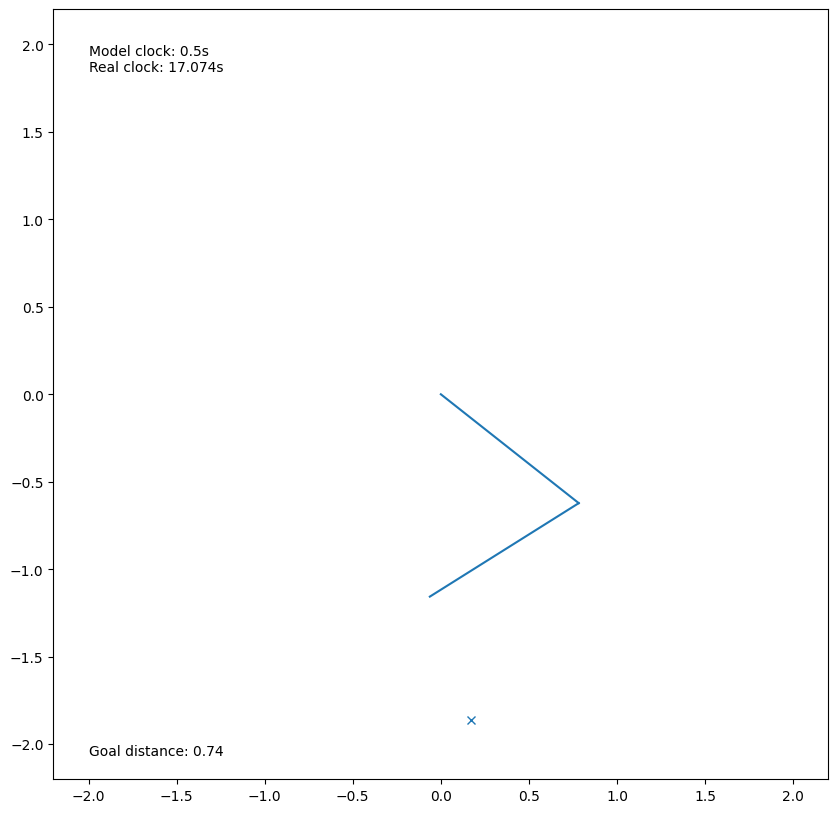

In [5]:
from render import Renderer
from arm_env import ArmEnv
from robot import Robot
from arm_dynamics import ArmDynamics
import numpy as np

# DO NOT CHANGE arm parameters
arm = Robot(
        ArmDynamics(
            num_links=2,
            link_mass=0.1,
            link_length=1,
            joint_viscous_friction=0.1,
            dt=0.01,
	    			gravity=False
        )
    )
arm.reset()
# ------------------


# Arm environment - An “Environment” is a way to standardize a problem for RL libraries
"""
class ArmEnv(gym.Env):

    - def __init__(self, arm, gui=False):
        - set obs space, goal, action space
        - step duration = 0.01
        - episode length = 200

    - def set_goal(self, goal):
        - call this function to set the goal for arm during testing

    - def step(self, action):
        - takes an action as a (2,1) shaped array
        - executes an action and returns obs, reward, done, info
            - Action space: continuous torques --> must map from discrete action indices manually
        - tells you the next observation
        - In this project, observation = state + goal information (+ ee position)
            - Obs space - 8 values: 4 for the state, 2 for the pos_ee and 2 for the goal
        - info is a dictionary with pos_ee and vel_ee values --> use for reward engineering
        - computes the reward function: negative squared distance between end-effector and goal
            - reward = - dist(pos_ee, goal)^2
        - computes the next step of the robotic arm - advances the environment, checks if episode is “done”
        - Needs a continuous action, so always convert discrete → continuous

    - def reset(self, goal=None):
        - resets the robotic arm in a vertically downwards pos
        - starts a new episode
        - randomizes goal if none given

    - def get_obs(self):
        - returns the current observation of the robotic arm
        - uses the state and pos_ee to compute the observation

    - def seed(self, seed=None):
        - for repeatability stochasticity
"""
env = ArmEnv(arm, gui=True)

# Passing our own defined goal to the reset function
#goal = np.array([[0.5], [-1.5]])
#obs = env.reset(goal)

# Resetting the environment without the goal will set a random goal position
obs = env.reset() # reset the arm in the vertically downwards position and set a new random goal by calling the random_goal() method

# random policy interacting with the ArmEnv for 50 steps (0.5 seconds)
for _ in range(50):
    rand_action = np.random.uniform(-1.5, 1.5, (2,1))
    obs, reward, done, info = env.step(rand_action) # takes an action as a (2,1) shaped array and outputs the next observation, reward, done and info

### QNetwork
This class defines the architecture of your network. You must fill in the __init__(...) function which defines your network, and the forward(...) function which performs the forward pass.

Your action space should be discrete, with whatever cardinality you decide. The size of the output layer of your Q-Network should thus be the same as the cardinality of your action space. When selecting an action, a policy must choose the one that has the highest estimated Q-value for the current state. As part of the QNetwork class, we are providing the function select_discrete_action(...) which does exactly that.

The arm environment itself however expects a 2-dimensional, continuous action vector. Therefore, when it comes to send an action to the environment, you must provide the kind of action the environment expects. It is your job to determine how to convert between the discrete action space of your Q-Network and the continuous action space of the arm. You do this by filling in the action_discrete_to_continuous(...) function in your QNetwork. You can expect to call the step function of the environment like this:

```
self.env.step(self.q_network.action_discrete_to_continuous(discrete_action))
```

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

"""
Use DQN (Deep Q-Network) and PPO (Proximal Policy Optimization) to solve a robot reaching task with a 2-link arm

You will build and train a neural network to control the arm to reach a goal position
    - Build your own agent with discrete actions → continuous control
    - It needs to choose actions and convert discrete actions to continuous torques for the robot (conversion dictionary)
    - Use a neural network to satisfy the Bellman equations
        - value function (deterministic and non-deterministic) is expected value of return if we follow the policy --> introduce stochasticity
        - a solved value function that is solved from Bellman equations has the future "baked in"
        - use Bellman equations to update the value of each square depending on its neighbors
            - repeatedly do this and after enough iterations the model will converge
        - once the Bellman equation is satisfied for every state, then the value function is complete

Q-learning:
    - q(s,a)=(1-alpha)q(s,a) + alpha[r(s,a)+gamma*v(s')]
    - q(s,a)=(1-alpha)q(s,a) + alpha[r(s,a)+gamma*max_a'(q(s',a'))]
    - write the values in a table
    - let the agent operate in the table
    - use a greedy policy to choose the best action
    - update the table from updated rule that comes from the Bellman equations
        - use the Bellman equations to update the value of each square depending on its neighbors
        - an update rule based on a Bellman equation is used to update the table as the agent gains experience
    - after a few iterations, the agent figures out that if they follow a good path, they will get good results
    - Problem: policy is exploring what it knows, but it has stopped exploring for an optimal path
    - Solution: add random exploration with ε probability at each step --> ε-greedy policy
    - Provable to converge to real q*(optimal action-value function) as long as policy allows for some random "exploration"
        - attempts to come up with better and better estimates of q* by exploring the world
        - current estimate of q* provided by:
            - exhaustive lookup table (Q-learning)
            - deep neural network (deep Q-learning)
        - every action taken gives us new information to update estimate of q*
        - follow ε-greedy policy with respect to current estimate of q* (greedy policy is optimal, but ε is needed to ensure exploration)
    - Can turn off exploration once we believe the algorithm has converged and start "exploiting" the policy
    - Key concepts in RL: exploration and exploitation

Goal: Learn a Q-function that estimates expected rewards for each action

Input: the state (positions, velocities, and goal info)
Output: a Q-value for each discrete action

Loss function:  L = Q(s_t, a_t) - [r_t + 𝛾 * max_(a’)Q(s_t+1, a)]
    - Loss function = what i knew before - what i just learned
    - Q(s,a): Value of taking action a in state s
    - γ (gamma): Discount factor for future rewards
"""

class QNetwork(nn.Module):

  def __init__(self, env, device):

    super(QNetwork, self).__init__()

    self.device = device

    """
    Goal: Define network architecture (input layer, hidden layers, output layer)

    Input size = length of observation (state + goal info)
    Output size = number of discrete actions you define
    Some hidden layers (usually 2-3 fully connected layers)
    """

    obs_dim = env.observation_space.shape[0]  # Obs space - 8 values: 4 for the state, 2 for the pos_ee and 2 for the goal
    num_actions = 5  # Choose the number of discrete actions

    self.fc1 = nn.Linear(obs_dim, 128)     # first fully connected layer
    self.fc2 = nn.Linear(128, 128)          # second fully connected layer
    self.fc3 = nn.Linear(128, num_actions) # output layer - DQN will require an action space that is 1-dimensional and discrete.

    #self.fc1 = nn.Linear(obs_dim, 64)     # input layer
    #self.fc2 = nn.Linear(64, 128)         # second hidden layer
    #self.fc3 = nn.Linear(128, 512)        # third hidden layer
    #self.fc4 = nn.Linear(512, 128)        # fourth hidden layer
    #self.fc5 = nn.Linear(128, 64)         # fifth hidden layer
    #self.fc6 = nn.Linear(64, num_actions) # output layer (one q-value per action)

  def forward(self, x, device):

    x = torch.tensor(x, dtype=torch.float32).to(device) # convert x to a tensor
    x = torch.relu(self.fc1(x))         # activation function for first layer
    x = torch.relu(self.fc2(x))         # activation function for second layer
    x = self.fc3(x)                     # no activation for output layer --> raw scores for Q-values

    return x

    #x = x.to(self.device)  # Ensure x is on the correct device
    #x = torch.relu(self.fc1(x))
    #x = torch.relu(self.fc2(x))
    #x = torch.relu(self.fc3(x))
    #x = torch.relu(self.fc4(x))
    #x = torch.relu(self.fc5(x))
    #self.q_values = self.fc6(x)  # actions

    #return self.q_values

  def select_discrete_action(self, obs, device):

    """
    Run a forward pass
    Pick the action (index) with the highest Q-value
    """

    # Convert obs to tensor and move to the correct device:
    #obs = torch.tensor(obs, dtype=torch.float32, device=device) # This change will correct type before passing to the network

    # Put the observation through the network to estimate q values for all possible discrete actions
    est_q_vals = self.forward(obs.reshape((1,) + obs.shape), device)

    # Choose the discrete action with the highest estimated q value
    discrete_action = torch.argmax(est_q_vals, dim=1).tolist()[0]

    return discrete_action

  def action_discrete_to_continuous(self, discrete_action):

    """
    - Convert between the discrete action space of your Q-Network and the continuous action space of the robotic arm
    - Conversion dictionary
    - Map a discrete action index to a real torque [μ_1, μ_2]
    - Mapping:
        - Choose a small number of discrete actions
        - Manually define what each discrete action means in terms of torques
    """

    # Conversion dictionary
    torque_candidates = {
        0: [-1.0, -1.0],
        1: [-1.0,  1.0],
        2: [ 1.0,  1.0],
        3: [ 1.0, -1.0],
        4: [ 0.0,  0.0]
    }
    action = np.array(torque_candidates[discrete_action]).reshape((2,1))

    return action

In [7]:
# Verify QNetwork
env = ArmEnv(arm)
device = torch.device('cpu')

qnet = QNetwork(env, device)
obs = env.reset()   # sets random goal
obs = torch.tensor(obs, dtype=torch.float32)

#print(f"Goal: {goal}")

discrete_action = qnet.select_discrete_action(obs, device)
continuous_action = qnet.action_discrete_to_continuous(discrete_action)

print("Discrete action:", discrete_action)
print("Continuous torque:", continuous_action)

Discrete action: 2
Continuous torque: [[1.]
 [1.]]


/content/geometry.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  R[0,0] = np.cos(theta)
<ipython-input-6-bd8fcb3b01ea>:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(device) # convert x to a tensor


We provide you with code to use the replay buffer in your RL implementation. You do not need to change the ReplayBuffer class.
```
rb = ReplayBuffer()
```
After creating a ReplayBuffer object you can add samples in the buffer using `put()`:
```
rb.put((obs, action, reward, next_obs, done))
```
Take random samples from the buffer using:
```
obs, actions, rewards, next_obses, dones = rb.sample(batch_size)
```


In [8]:
import collections
import random
import numpy as np


class ReplayBuffer():
    def __init__(self, buffer_limit):
        self.buffer = collections.deque(maxlen=buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append(a)
            r_lst.append(r)
            s_prime_lst.append(s_prime)
            done_mask_lst.append(done_mask)

        return np.array(s_lst), np.array(a_lst), \
               np.array(r_lst), np.array(s_prime_lst), \
               np.array(done_mask_lst)

### TrainDQN
Here, you must fill in the train(...) function that actually trains your network.

We are providing a helper function called save_model(...) that will save the current Q-network. Use this as you see fit.

To set one network equal to another one, you can use code like this:
```
target_network.load_state_dict(self.q_network.state_dict())
```

If you would like to be graded with a specific seed for the random number generators, make sure to change the default seed in the initialization of the TrainDQN class.

The time taken to train the model will depend mainly on how big is your model architecture and the number of episodes you run the training for. As a reference, the time taken to train a model on 1500 episodes, which passed all evaluation metrics was about an hour.
* Reference value for clipping the gradient value as mentioned in class: 0.2
* Reference value for a typical size of Replay Buffer: >10k
* Reference value for batch size while training: 64 - 512

Note that these are just reference values and larger is not always better as it may slow things down.

It is good practice in RL to ensure simpler things are working before complicating environments or training techniques.

If you think your training method is not working at all, you could pass a fixed goal to the `env.reset()` method during the training loop to ensure that your model is learning.

In [9]:
import time
from render import Renderer
from arm_env import ArmEnv
import numpy as np
from math import dist
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import torch.optim as optim


"""
Q-learning:
    - q(s,a)=(1-alpha)q(s,a) + alpha[r(s,a)+gamma*v(s')]=(1-alpha)q(s,a) + alpha[r(s,a)+gamma*max_a'(q(s',a'))]
    - use a greedy policy to choose the best action
    - update the table
    - after a few iterations, the agent figures out that if they follow a good path, they will get good results
    - policy is exploring what it knows, but it has stopped exploring for an optimal path
    - solution: add random exploration with ε probability at each step --> ε-greedy policy
    - provable to converge to real q* as long as policy allows for some random "exploration"
    - can turn off exploration once we believe the algorithm has converged and start "exploiting" the policy

Deep Q-Learning:
    Initialize action-value function Q with random weights
    for episode = 1,M do:
        Initialize s_1=x_1 (image in start state)
        for t=1,T do:
            With probability ε, a_t=random; otherwise a_t=max_a(Q(s_t,a))
            Execute a_t and observe reward r_t, next image x_t+1
            Compute loss L = Q(s_t, a_t) - [r_t + 𝛾 * max_(a’)Q(s_t+1, a)]
            Perform gradient descent step on Q according to loss L
            Set s_t=s_t+1
        end for
    end for
"""


#def linear_decay(start, end, current_step, decay_steps):
    #"""
    #Linearly decay epsilon from `start` to `end` over `decay_steps` total steps.
    #After that, stay at `end`.

    #Allows for a gradual shift from exploration to exploitation --> Greedy policy
    #"""
    #if current_step >= decay_steps:
        #return end
    #else:
        #return start - (start - end) * (current_step / decay_steps)

class TrainDQN:

    def __init__(self, env, seed=42):

        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        self.env = env
        self.device = torch.device('cpu')
        self.q_network = QNetwork(env, self.device).to(self.device)
        self.target_network = QNetwork(env, self.device).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())

        # Adam optimizer
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=1e-3)

    def save_model(self, episode_num, save_dir='models'):

        timestr = time.strftime("%Y-%m-%d_%H-%M-%S")
        model_dir = os.path.join(save_dir, timestr)
        if not os.path.exists(os.path.join(model_dir)):
          os.makedirs(os.path.join(model_dir))
        savepath = os.path.join(model_dir, f'q_network_ep_{episode_num:04d}.pth')
        torch.save(self.q_network.state_dict(), savepath)
        print(f'model saved to {savepath}\n')

    def train(self):

        # Initialize constants
        num_episodes = 1500
        #max_steps = 200
        batch_size = 64
        buffer_size = 10000
        gamma = 0.99
        target_update_freq = 10

        # Replay buffer for experience replay
        rb = ReplayBuffer(buffer_size)

        # Linear decay - This method decays ε smoothly and linearly from 1.0 → 0.01 over the defined number of steps, then keeps it constant at 0.01 for the rest of training
        #epsilon_start = 1.0
        #epsilon_end = 0.01
        #epsilon_decay = 100000  # Decay epsilon over 100,000 environment steps

        #global_step = 0

        returns = []

        """Initialize action-value function Q with random weights - class QNetwork(nn.Module) from before"""

        for episode in range(1, num_episodes + 1):

            """Initialize s_1 = x_1 (image in start state) - at the beginning of each episode, reset the environment and get the initial observation"""
            state = self.env.reset()
            state = torch.tensor(state, dtype=torch.float32).to(self.device)
            # obs is the initial observation x_1, which becomes the starting state s_1
            #obs = self.env.reset()  # start new episode and randomize goal if given none
            #obs = torch.tensor(obs, dtype=torch.float32).to(self.device)  # convert to a tensor

            total_loss = 0
            episode_reward = 0
            total_steps = 0

            while True:
            #for t in range(1, max_steps + 1):

                # Epsilon-greedy exploration
                #epsilon = linear_decay(epsilon_start, epsilon_end, global_step, epsilon_decay) # Allows for a gradual shift from exploration to exploitation

                #"""ε-greedy action selection - use a greedy policy to choose the best action"""
                # Exploration - with probability ε, select a random action
                #if random.random() < epsilon:
                    #action = random.randint(0, self.q_network.fc3.out_features - 1)
                # Exploitation - with probability ε-1, select best action using the Q-network
                #else:
                    #with torch.no_grad():
                        #q_values = self.q_network(obs.unsqueeze(0), self.device)
                        #action = torch.argmax(q_values).item()

                """Execute action a_t and observe reward r_t, next state (next image x_t+1)"""

                # Get Q-values for the current state
                q_values = self.q_network(state.unsqueeze(0), self.device)

                # Select the action with the highest Q-value
                discrete_action = q_values.max(1)[1].item()

                # Use discrete actions for training and convert them to continuous torques before stepping into the environment
                continuous_action = self.q_network.action_discrete_to_continuous(discrete_action) # Convert the discrete action to continuous before stepping

                # Step environment using the continuous action
                next_state, reward, done, info = self.env.step(continuous_action)
                #next_obs, reward, done, info = self.env.step(continuous_action)

                # Next state (image x_t+1)
                next_state = torch.tensor(next_state, dtype=torch.float32).to(self.device)
                #next_obs_tensor = torch.tensor(next_obs, dtype=torch.float32).to(self.device)

                # Done
                #done_mask = 0.0 if done else 1.0  # 0 if terminal state, 1 otherwise

                # Store the next steps - transition
                transition = (state.numpy(), discrete_action, reward, next_state.numpy(), done)
                #transition = (obs.cpu().numpy(), action, reward, next_obs_tensor.cpu().numpy(), done_mask) # ensures replay buffer only stores discrete action indices, which match the Q-values output of the network
                #transition = (obs.cpu().numpy(), continuous_action, reward, next_obs_tensor.cpu().numpy(), done_mask)

                # Save this transition in the replay buffer (for experience replay)
                rb.put(transition)  # After creating a ReplayBuffer object you can add samples in the buffer using put()

                episode_reward += reward
                #obs = next_obs_tensor
                #global_step += 1

                """Compute loss L = Q(s_t, a_t) - [r_t + 𝛾 * max_(a’)Q(s_t+1, a)]
                - MSE loss between the Q-value of the current state-action pair (predicted by q_network)
                - and the target (which is the reward plus discovered max Q-value of next state from target_network)"""

                # Training Step - start training when buffer has enough samples
                if len(rb.buffer) >= batch_size:

                    states, actions, rewards, next_states, dones = rb.sample(batch_size)

                    # Convert to tensors
                    states = torch.tensor(states, dtype=torch.float32, device=self.device)
                    actions = torch.tensor(actions, dtype=torch.long, device=self.device).unsqueeze(1)
                    rewards = torch.tensor(rewards, dtype=torch.float32, device=self.device).unsqueeze(1)
                    next_states = torch.tensor(next_states, dtype=torch.float32, device=self.device)
                    dones = torch.tensor(dones, dtype=torch.float32, device=self.device).unsqueeze(1)

                    # Compute Q(s_t, a_t) from the main Q-network
                    #q_values = self.q_network(states).gather(1, actions)
                    q_values = self.q_network(states, self.device).gather(1, actions) # Pass the device to the forward method

                    # Compute the target value (Target Q: r + gamma * max(Q(s',a'))) using target_network
                    #with torch.no_grad():
                    next_q_values = self.target_network(next_states, self.device)
                    max_next_q_value = next_q_values.max(1)[0].unsqueeze(1)
                    target_q_values = rewards + gamma * max_next_q_value * (1- dones)

                    # Compute the Loss (MSE)
                    loss = F.mse_loss(q_values, target_q_values)

                    """Perform gradient descent step on Q according to loss L"""
                    self.optimizer.zero_grad()  # Reset gradients
                    loss.backward()             # Compute gradients via backpropagation
                    nn.utils.clip_grad_norm_(self.q_network.parameters(), max_norm=0.2)  # Gradient clipping
                    self.optimizer.step()       # Apply gradients to update Q-network weights

                    total_loss += loss.item()
                    total_steps += 1

                if done:
                    break

                # Update state
                state = next_state

            # Update target network
            if episode % target_update_freq == 0:
                self.target_network.load_state_dict(self.q_network.state_dict())
                #print(f"Episode {episode} / {num_episodes} | Target network updated.")

            # Save model every 100 episodes
            if episode % 100 == 0:
                self.save_model(episode)

            #print(f"Episode {episode} / {num_episodes} | Loss: {loss.item():.4f} | Reward: {episode_reward:.2f} | Epsilon: {epsilon:.3f}")
            print(f"Episode {episode} / {num_episodes} | Loss: {loss.item():.4f} | Reward: {episode_reward:.2f} ")

In [10]:
from robot import Robot
from arm_dynamics import ArmDynamics

# DO NOT CHANGE
# ---------------
arm = Robot(
        ArmDynamics(
            num_links=2,
            link_mass=0.1,
            link_length=1,
            joint_viscous_friction=0.1,
            dt=0.01,
	    			gravity=False
        )
    )
arm.reset()
env = ArmEnv(arm, gui=False)
tqdn = TrainDQN(env)
# ---------------

# Call your trin function here
tqdn.train()

/content/geometry.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  R[0,0] = np.cos(theta)
<ipython-input-6-bd8fcb3b01ea>:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(device) # convert x to a tensor
/content/arm_dynamics.py:113: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  right_hand[self.idx_tau_eqbm(i), 0] += (tau[i + 1] if i < self.num_links - 1 else 0.0) - tau[i]


Episode 1 / 1500 | Loss: 0.4118 | Reward: -420.00 
Episode 2 / 1500 | Loss: 3.0897 | Reward: -1502.10 
Episode 3 / 1500 | Loss: 0.8259 | Reward: -864.83 
Episode 4 / 1500 | Loss: 1.0746 | Reward: -877.52 
Episode 5 / 1500 | Loss: 0.7183 | Reward: -889.96 
Episode 6 / 1500 | Loss: 0.7170 | Reward: -653.62 
Episode 7 / 1500 | Loss: 0.8790 | Reward: -1052.78 
Episode 8 / 1500 | Loss: 0.4681 | Reward: -788.53 
Episode 9 / 1500 | Loss: 0.8323 | Reward: -908.57 
Episode 10 / 1500 | Loss: 0.5227 | Reward: -963.70 
Episode 11 / 1500 | Loss: 1.5351 | Reward: -919.19 
Episode 12 / 1500 | Loss: 1.0757 | Reward: -990.98 
Episode 13 / 1500 | Loss: 0.7835 | Reward: -819.44 
Episode 14 / 1500 | Loss: 0.8522 | Reward: -956.93 
Episode 15 / 1500 | Loss: 0.4688 | Reward: -839.21 
Episode 16 / 1500 | Loss: 0.4931 | Reward: -1086.01 
Episode 17 / 1500 | Loss: 0.6227 | Reward: -670.46 
Episode 18 / 1500 | Loss: 0.8319 | Reward: -1236.11 
Episode 19 / 1500 | Loss: 0.6968 | Reward: -904.59 
Episode 20 / 1500

To keep track of your experiments, it is good practice to plot and check how well is your model trained based on the returns vs episodes plot. With a large number of episodes, this  plot may look very jagged making it difficult to ascertain how well you are doing. We are proving code to smoothen out the plot by. This will take a large list of returns in every episode and plot a smoothened version of the list. Feel free to use it if it helps.
```
import seaborn as sns
returns = __
smoothing = 10

smoothened = [sum(returns[i:i+smoothing])/smoothing for i in range(0, len(returns), smoothing)]
sns.lineplot(smoothened)
```

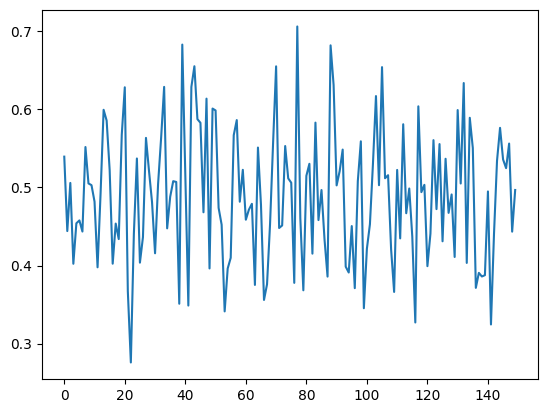

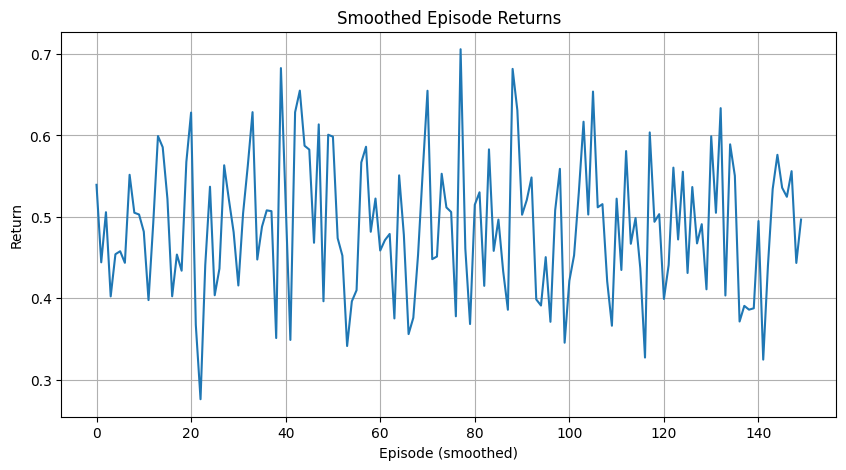

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

returns = [np.random.rand() for _ in range(1500)]
smoothing = 10

# Smooth the return values
smoothened = [sum(returns[i:i+smoothing])/smoothing for i in range(0, len(returns), smoothing)]
sns.lineplot(smoothened)

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(len(smoothened)), y=smoothened)
plt.xlabel("Episode (smoothed)")
plt.ylabel("Return")
plt.title("Smoothed Episode Returns")
plt.grid(True)
plt.show()

### Load your model and test its performance
Change your model path and the goal to see how well your learnt model is performing

In [12]:
import os
import torch
import numpy as np
from render import Renderer
from arm_env import ArmEnv
from robot import Robot
from arm_dynamics import ArmDynamics
from geometry import polar2cartesian

# Define fixed test goal
test_goal = polar2cartesian(1.6, 0.25 - np.pi/2.0)

# Environment setup (same as before)
arm = Robot(
    ArmDynamics(
        num_links=2,
        link_mass=0.1,
        link_length=1,
        joint_viscous_friction=0.1,
        dt=0.01,
        gravity=False
    )
)
env = ArmEnv(arm, gui=False)

device = torch.device('cpu')

# Set your model directory path
model_root_dir = 'models'

def evaluate_model(model_path, num_episodes=5):
    qnet = QNetwork(env, device).to(device)
    qnet.load_state_dict(torch.load(model_path))
    qnet.eval()

    returns = []
    for _ in range(num_episodes):
        obs = env.reset(goal=test_goal)
        done = False
        episode_return = 0

        while not done:
            action = qnet.select_discrete_action(obs, device)
            action = qnet.action_discrete_to_continuous(action)
            obs, reward, done, info = env.step(action)
            episode_return += reward

        returns.append(episode_return)

    return np.mean(returns)

# Loop through all saved models and evaluate
best_model_path = None
best_return = -float('inf')

for subdir, _, files in os.walk(model_root_dir):
    for file in files:
        if file.endswith('.pth'):
            model_path = os.path.join(subdir, file)
            avg_return = evaluate_model(model_path)

            print(f"{model_path}: Avg Return = {avg_return:.2f}")
            if avg_return > best_return:
                best_return = avg_return
                best_model_path = model_path

print(f"\nBest model: {best_model_path} with Avg Return = {best_return:.2f}")

/content/geometry.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  R[0,0] = np.cos(theta)
/content/arm_dynamics.py:113: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  right_hand[self.idx_tau_eqbm(i), 0] += (tau[i + 1] if i < self.num_links - 1 else 0.0) - tau[i]


models/2025-05-12_01-24-20/q_network_ep_0200.pth: Avg Return = -34.35
models/2025-05-12_01-34-13/q_network_ep_0800.pth: Avg Return = -2.19
models/2025-05-12_01-44-35/q_network_ep_1400.pth: Avg Return = -2.88
models/2025-05-12_01-32-33/q_network_ep_0700.pth: Avg Return = -2.37
models/2025-05-12_01-46-21/q_network_ep_1500.pth: Avg Return = -2.95
models/2025-05-12_01-39-23/q_network_ep_1100.pth: Avg Return = -2.51
models/2025-05-12_01-35-56/q_network_ep_0900.pth: Avg Return = -1.96
models/2025-05-12_01-42-51/q_network_ep_1300.pth: Avg Return = -2.14
models/2025-05-12_01-27-33/q_network_ep_0400.pth: Avg Return = -10.65
models/2025-05-12_01-22-50/q_network_ep_0100.pth: Avg Return = -1025.94
models/2025-05-12_01-25-57/q_network_ep_0300.pth: Avg Return = -19.00
models/2025-05-12_01-37-40/q_network_ep_1000.pth: Avg Return = -156.05
models/2025-05-12_01-41-07/q_network_ep_1200.pth: Avg Return = -5.11
models/2025-05-12_01-30-51/q_network_ep_0600.pth: Avg Return = -13.51
models/2025-05-12_01-29-1

### Grading and Evaluation
You will be evaluated on 5 different goal positions worth 1.5 points each. You must pass the best `model_path` for your network. The scoring function will run one episode for every goal position and find the total reward (aka return) for the episode. For every goal you get:

* 1 Point if `easy target < total reward < hard target`
* 1.5 Points if `hard target < total reward`

In [13]:
from score import compute_score
import torch.nn as nn
import torch
import torch.nn.functional as F
from render import Renderer
from arm_env import ArmEnv
from robot import Robot
from arm_dynamics import ArmDynamics
import numpy as np
import glob

# DO NOT CHANGE arm parameters
arm = Robot(
        ArmDynamics(
            num_links=2,
            link_mass=0.1,
            link_length=1,
            joint_viscous_friction=0.1,
            dt=0.01,
	    			gravity=False
        )
    )
arm.reset()
# ------------------

env = ArmEnv(arm, gui=False)

model_path = best_model_path
print(f"Model path: {model_path}\n")

device = torch.device('cpu')
qnet = QNetwork(env, device).to(device)
qnet.load_state_dict(torch.load(model_path))
qnet.eval()
score = compute_score(qnet, env, device)

Model path: models/2025-05-12_01-35-56/q_network_ep_0900.pth

---Computing score---

Goal 1:
Total reward: -10.407697533070106
easy target: -7
hard target: -5
points: 0

Goal 2:
Total reward: -1.9613467928047124
easy target: -7
hard target: -5
points: 1.5

Goal 3:
Total reward: -1.7182117021949264
easy target: -7
hard target: -5
points: 1.5

Goal 4:
Total reward: -3.021891924130511
easy target: -7
hard target: -5
points: 1.5

Goal 5:
Total reward: -3.8109615785153084
easy target: -10
hard target: -7
points: 1.5


Final score: 6.0


# Part 2: PPO with an open source RL library

In this part, you will use one of the most popular open source RL libraries ([Stable-Baselines3](https://stable-baselines3.readthedocs.io/en/master/)) to solve the same goal reaching problem as Part 1. We will use the same `ArmEnv` gym environment. The algorithm you should choose to use is PPO.

## PPO training

We provide the code to construct parallel environments. Parallel environments can be very useful if you have good CPUs and it can speed up training.

In [14]:
# DO NOT CHANGE

from stable_baselines3.common.vec_env.subproc_vec_env import SubprocVecEnv
from stable_baselines3.common.vec_env.vec_monitor import VecMonitor
from copy import deepcopy
from robot import Robot
from arm_dynamics import ArmDynamics
from arm_env import ArmEnv

# Code to construct parallel environments

class EnvMaker:
    def __init__(self,  arm, seed):
        self.seed = seed
        self.arm = arm

    def __call__(self):
        arm = deepcopy(self.arm)
        env = ArmEnv(arm)
        env.seed(self.seed)
        return env

def make_vec_env(arm, nenv, seed):
    return VecMonitor(SubprocVecEnv([EnvMaker(arm, seed  + 100 * i) for i in range(nenv)]))

# conveniet function to create a robot arm
def make_arm():
    arm = Robot(
        ArmDynamics(
            num_links=2,
            link_mass=0.1,
            link_length=1,
            joint_viscous_friction=0.1,
            dt=0.01
        )
    )
    arm.reset()
    return arm


You will need to complete the code to train the policy using the [PPO class](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html) from stable_baselines3. We provide the code to generate the name of the directory to save the checkpoint, an example is `ppo_models/2025-04-21_01-14-13`. Your checkpoint model should be named `ppo_network.zip`. See the [save](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html#stable_baselines3.ppo.PPO.save) function. Training should take less than 40 minutes.

In [15]:
from stable_baselines3.ppo import PPO
import os
import time
from stable_baselines3.common.utils import set_random_seed

# Code to train the PPO policy
"""
PPO (Proximal Policy Optimization)
    - developed by OpenAI that balances ease of implementation, sample efficiency, and reliable performance
    - policy gradient method - meaning it learns a parameterized policy (typically a neural network) that directly maps states to actions, and updates this policy based on how good the actions are
    - designed to overcome limitations of previous methods like TRPO (Trust Region Policy Optimization)
        - being simpler to implement
        - avoiding complex second-order optimization
        - achieving stable and reliable learning
    - core idea: prevent the updated policy from diverging too far from the old policy
        - clipping the objective function to limit how much the policy can change at each update
        - using multiple epochs of minibatch stochastic gradient ascent on the collected data
"""

# Default parameters
timesteps = 500000
nenv = 8  # number of parallel environments. This can speed up training when you have good CPUs
seed = 8
batch_size = 2048

# Generate path of the directory to save the checkpoint
timestr = time.strftime("%Y-%m-%d_%H-%M-%S")
save_dir = os.path.join('ppo_models', timestr)

# Set random seed
set_random_seed(seed)

# Create arm
arm = make_arm()

# Create parallel envs
vec_env = make_vec_env(arm=arm, nenv=nenv, seed=seed)

# Create the PPO model
model = PPO(
    policy="MlpPolicy",
    env=vec_env,
    verbose=1,
    seed=seed,
    n_steps=batch_size,
    tensorboard_log="./ppo_tensorboard/"
)

# Train the model
model.learn(total_timesteps=timesteps)

# Create directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Save the model
model_path = os.path.join(save_dir, "ppo_network.zip")
model.save(model_path)

print(f"Model path: {model_path}")

Using cpu device
Logging to ./ppo_tensorboard/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -212     |
| time/              |          |
|    fps             | 790      |
|    iterations      | 1        |
|    time_elapsed    | 20       |
|    total_timesteps | 16384    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 200         |
|    ep_rew_mean          | -138        |
| time/                   |             |
|    fps                  | 638         |
|    iterations           | 2           |
|    time_elapsed         | 51          |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.005548088 |
|    clip_fraction        | 0.0556      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.85       |
|    explained_varia

## Grading and evaluation

The total number of points for Part 2 is 7.5. We will evaluate your trained model on 5 random goal locations. For each test, we assign points based on the distance between the end effector and the goal location at the end of the episode.

- If 0 < distance < 0.05, you get 1.5 points.
- If 0.05 <= distance < 0.1, you get 1 point.
- If distance >= 0.1, you get 0 point.



In [16]:
from score import score_policy
from stable_baselines3 import PPO
from stable_baselines3.common.utils import set_random_seed
from robot import Robot
from arm_dynamics import ArmDynamics
from render import Renderer
import time

# Set the path to your model
model_path = model_path

set_random_seed(seed=100)

# Create arm robot
arm = make_arm()

# Create environment
env = ArmEnv(arm, gui=False)
env.seed(100)

# Load and test policy
policy = PPO.load(model_path)
score_policy(policy, env)


--- Computing score ---


/content/geometry.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  R[0,0] = np.cos(theta)



Goal 1: 1.5

Goal 2: 1.5

Goal 3: 1.5

Goal 4: 1.5

Goal 5: 1.5


---
Final score: 7.5/7.5
---


7.5